In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
figure_size = (14,7)

In [92]:
wine_df = pd.read_csv('data/winemag-data-130k-v2.csv').drop(columns=['Unnamed: 0'])

# [10 Points, half a page] Project description and summary. This part should summerise your goal, your approach, and your results.

In this project we are using the Wine Review dataset. We start by exploring the data and find interesting insights. We then fit 2 separate regression models to predict wine points. The first model I used is a linear regression with price and province as features. The results were okay, a 7.20 mean squared error and 0.23 R^2 score. The second model is a gradient boosted model with TF-IDF features to process text data. This model performed better achieving a 3.76 mean squared error and a 0.59 R^2 score.  

On the wine recommendations, a similar model is used for text searching. We search for nearest neighbors giving a keyword and then filter the results by the price. This shows good results overall. 

# [10 Points, within 1 page] Data processing. Describe how you process the data so that it can be analyzed by a regression model. This includes, but not limited to, processing text data.

Data processing for the linear regression model is simple. I first fill any missing values with the price mean. This was done to avoid any invalid values. I then had to one hot encode the province. This means splitting the province column data to many columns depending on the number of categories present in that column. Each column contains 0 or 1 corresponding to which column it has been placed.

For the gradient boosted recommendations model, the data processing was a little more involved. I first remove any popular words in the english dictionary like "the" and "a". This reduces the amount of noise in the wine descriptions. I also converted word stems to the main word. Once I had a cleaned list of wine description, I then converted them to a matrix of term frequency-inverse document frequency(TF-IDF) features. This is a statistical measure used to evaluate how important a word is to a document in a collection

# [10 Points, within 1 page] Descriptive statistics with tables/figures. Provide summaries of your data, which may motivate your particular choice of the regression model.


## Get overall description and info of dataset

In [6]:
wine_df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


#### Mean Points by Province

In [11]:
grouped_by_provice= wine_df.groupby('province')[['province','points']].mean().reset_index().sort_values('points',ascending=False).head(50)

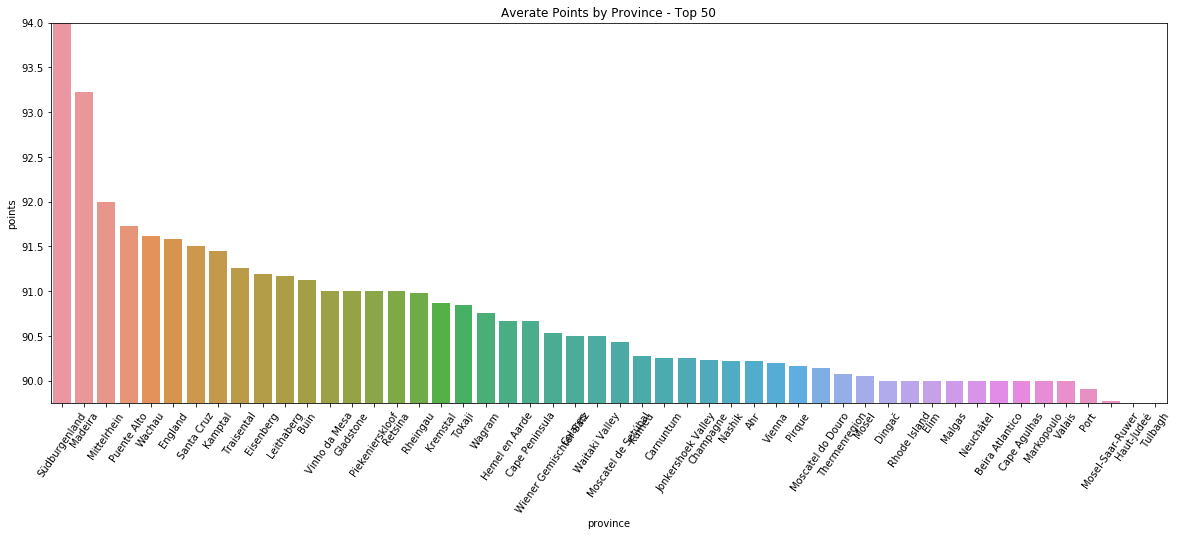

In [12]:
plt.figure(figsize=(20,7))
plt.title('Averate Points by Province - Top 50')
sns.barplot(x = 'province', y="points", data=grouped_by_provice)
locs, labels = plt.xticks()
plt.xticks(rotation=55)
plt.ylim(grouped_by_provice.min().points, grouped_by_provice.max().points)
plt.show()

#### Mean Points by Winery

In [13]:
grouped_by_winery= wine_df.groupby('winery')[['winery','points']].mean().reset_index().sort_values('points',ascending=False).head(25)

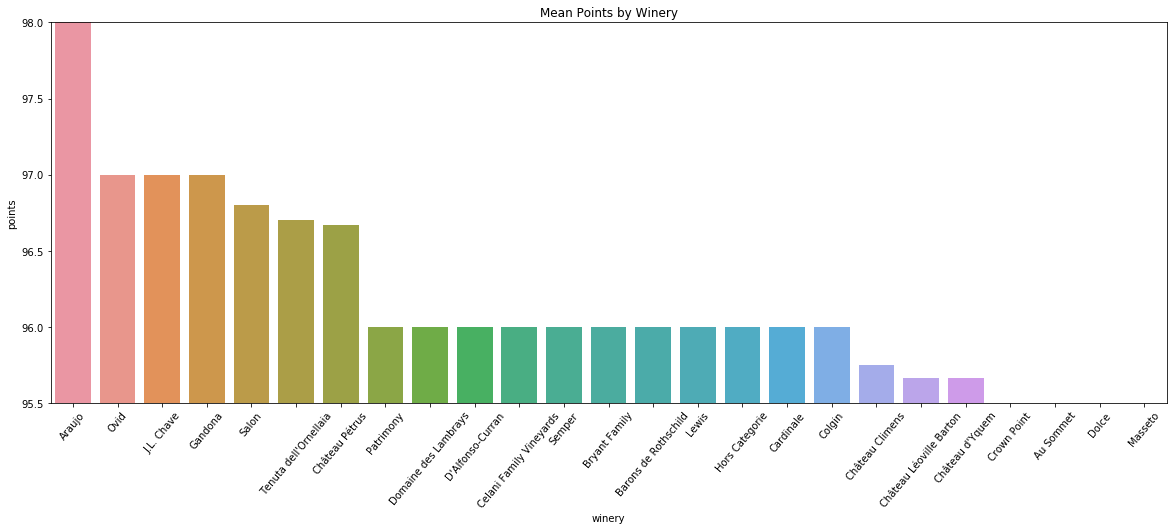

In [14]:
plt.figure(figsize=(20,7))
plt.title('Mean Points by Winery')
sns.barplot(x = 'winery', y="points", data=grouped_by_winery)
locs, labels = plt.xticks()
plt.xticks(rotation=50)
plt.ylim(grouped_by_winery.min().points, grouped_by_winery.max().points)
plt.show()

#### Price Distribution

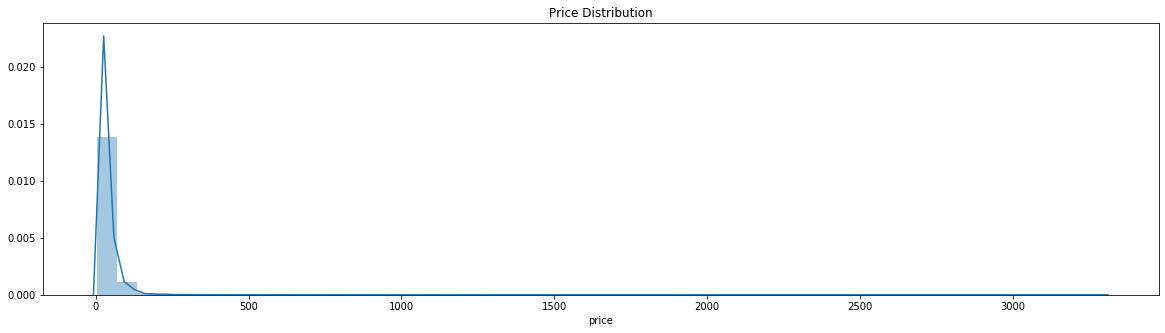

In [15]:
plt.figure(figsize=(20,5))
plt.title("Price Distribution")
ax = sns.distplot(wine_df["price"].dropna())

### Wine point distribution

In [16]:
points = wine_df["points"].value_counts()

In [17]:
points = pd.DataFrame({'points': points.index,'total': points.values})

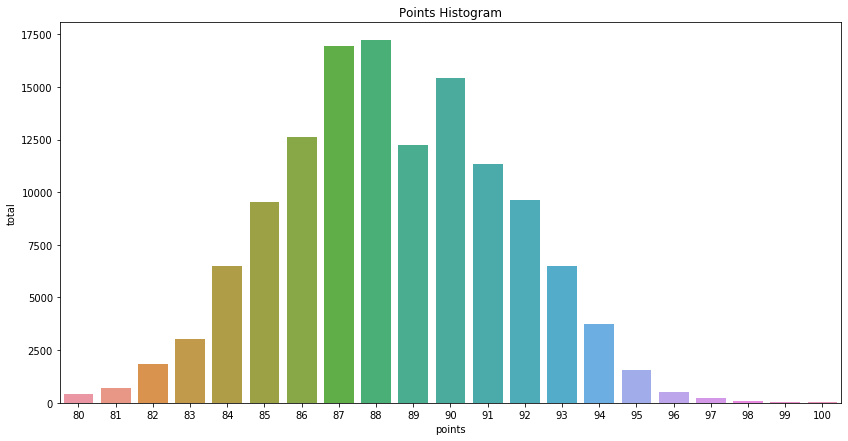

In [18]:
plt.figure(figsize = figure_size)
plt.title('Points Histogram')
sns.set_color_codes("pastel")
sns.barplot(x ='points', y='total', data=points)
locs, labels = plt.xticks()
plt.show()

# [35 Points, within 3 pages] Regression model analysis.

## Linear Regression Model 

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

#### Prepare data
Fill NA values with average. Choose price and country as input features. One hot encode country.

In [20]:
cleaned_df = wine_df.copy()

In [21]:
cleaned_df.price = cleaned_df.price.fillna(cleaned_df.price.mean())

In [22]:
selected_features = cleaned_df[['price','province']]

In [23]:
x = pd.get_dummies(selected_features,prefix=['province'])

In [24]:
y = cleaned_df.points.to_numpy()

#### Visualize the X and Y values in lower dimension

In [25]:
pca = PCA(n_components=1)

In [26]:
x_pca = pca.fit_transform(x).reshape(-1)

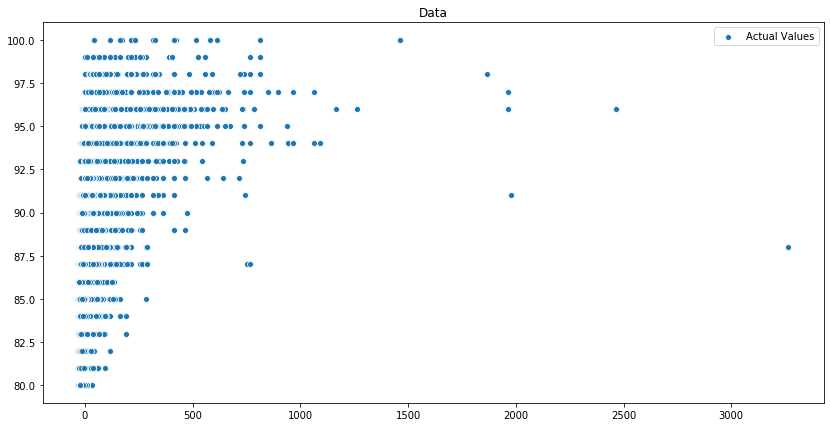

In [27]:
plt.figure(figsize = figure_size)
plt.title('Data')
sns.scatterplot(x_pca, y, label="Actual Values")
plt.show()

#### Split train/test data

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

#### Fit linear regression model

In [32]:
model = LinearRegression()

In [33]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
y_pred = model.predict(X_test)

In [35]:
f"MSE {mean_squared_error(y_test, y_pred)}"

'MSE 7.204910408282384'

In [37]:
F"R^2 score {model.score(X_test, y_test)}"

'R^2 score 0.23068763225176445'

#### Plot predicted values by doing PCA

In [38]:
pca = PCA(n_components=1)

In [39]:
X_test_pca = pca.fit_transform(X_test).reshape(-1)

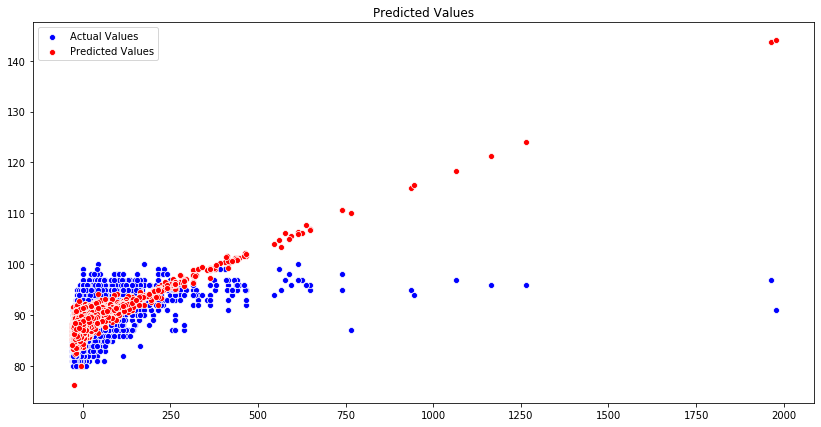

In [40]:
plt.figure(figsize = figure_size)
plt.title('Predicted Values')
sns.scatterplot(X_test_pca, y_test,color='blue', label="Actual Values")
sns.scatterplot(X_test_pca, y_pred,color='red', label="Predicted Values")
plt.show()

We can see that the red line is not as accurate. Some of the points are being estimated to be higher than 100, which is not what we want. 

## Adaboost Model 

In [48]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingRegressor
import re

### Prepare data. 

In [42]:
cleaned_df = wine_df.copy()

In [43]:
x = cleaned_df['description']

In [44]:
y = cleaned_df['points']

Convert description to lowercase. 

In [45]:
x = x.str.lower()

In [68]:
x = x.apply(lambda elem: re.sub('[^a-zA-Z]',' ', elem))  

### Let's tokenize sentences to list of words in order to feed them to the classifier. 

In [61]:
tokenizer = RegexpTokenizer(r'\w+')

In [66]:
words_descriptions = x.apply(tokenizer.tokenize)

### Remove any stopwords and convert word stems to one word. 

In [71]:
stopword_list = stopwords.words('english')

In [73]:
ps = PorterStemmer()

In [74]:
words_descriptions = words_descriptions.apply(lambda elem: [word for word in elem if not word in stopword_list])

In [76]:
words_descriptions = words_descriptions.apply(lambda elem: [ps.stem(word) for word in elem])

In [80]:
x_cleaned = words_descriptions.apply(lambda elem: ' '.join(elem))

### Let's convert the collection of reviews to a matrix of TF-IDF features.

In [100]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w+',max_features=500)

In [101]:
x_vectorized = vectorizer.fit_transform(x_cleaned)

### Fit the Adaboost regressor model

#### Split train/test data

In [122]:
X_train, X_test, y_train, y_test = train_test_split(x_vectorized, y, test_size=0.25, random_state=42)

In [133]:
regr = GradientBoostingRegressor()

In [134]:
regr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [140]:
regr.score(X_train, y_train)

0.45377043566858666

In [141]:
regr.score(X_test, y_test)

0.44992286051117486

#### We can do cross validation search to find the best set of params.

In [160]:
parameters = {'n_estimators':[200, 350], 'learning_rate':[.1,.25], 'max_depth': [3,4]}

In [161]:
regr = GradientBoostingRegressor()

In [164]:
gsmodel = GridSearchCV(regr, parameters, cv=2, n_jobs=-1, verbose=3)

In [ ]:
gsmodel.fit(X_train, y_train)

In [173]:
f"The best score is {gsmodel.best_score_} with the following params {gsmodel.best_params_}."

"The best score is 0.5754155537124865 with the following params {'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 350}"

In [181]:
best_model = gsmodel.best_estimator_

In [183]:
f"Score on tersting data is {best_model.score(X_test, y_test)}"

'Score on tersting data is 0.5979222662552914'

In [187]:
y_pred = best_model.predict(X_test)

In [189]:
f"MSE for best model {mean_squared_error(y_test, y_pred)}"

'MSE for best model 3.765614814272545'

# [20 Points, within 1 page] Recommend five different wineries for a customer that is interested in purchasing a pinot noir, with a price less than 20 dollars, and has a fruity taste.

In [560]:
wines = wine_df.copy()

## Data cleanup
Let's convert the variety and description to lowercase. We create a new `variety_description` column which we'll use later for our model. We also drop and null/na values. 

In [534]:
wines['winery'].dropna(inplace=True)

In [535]:
wines['variety'] = wines['variety'].str.lower()

In [536]:
wines['price'].dropna(inplace=True)

In [690]:
wines['variety_description'] = wines['description'] + ' ' +  wines['variety']

In [691]:
wines['variety_description'].dropna(inplace=True)

### Recommendations model
We will create a simple model using the created `variety_description` column using TF-IDF matrix similar to part 1. We use this model to search by a term and get the nearestneighbors, then we order by the points, count of reviews, and price. 

In [540]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
import string

#### Clean text data
Remove any stop words and get word stems. 

In [693]:
description = wines['variety_description']

In [694]:
description = description.apply(lambda elem: re.sub('[^a-zA-Z]',' ', elem))  

In [695]:
tokenizer = RegexpTokenizer(r'\w+')

In [696]:
words_description = description.apply(tokenizer.tokenize)

In [697]:
stopword_list = stopwords.words('english')

In [698]:
ps = PorterStemmer()

In [699]:
words_description = words_description.apply(lambda elem: [word for word in elem if not word in stopword_list])

In [700]:
words_description = words_description.apply(lambda elem: [ps.stem(word) for word in elem])

In [701]:
description_cleaned = words_description.apply(lambda elem: ' '.join(elem))

In [704]:
wines['variety_description_cleaned'] = description_cleaned

In [774]:
wines_by_winery = []

In [775]:
for winery in wines.winery.unique():
    winery_rows = wines.loc[wines['winery'] == winery]
    
    price = winery_rows.price.mean()
    points = winery_rows.points.mean()
    count = len(winery_rows)

    descriptions = winery_rows.variety_description_cleaned.str.cat(sep=' ')
    descriptions = winery_rows.variety_description_cleaned.str.cat(sep=' ')
        
    wines_by_winery.append({'winery': winery.lower().strip(), 'price': price, 'descriptions': descriptions, 'points': points, 'count': count})

In [777]:
wines_by_winery_df = pd.DataFrame(wines_by_winery)

In [778]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w+',max_features=500)

In [779]:
rec_vectorized = vectorizer.fit_transform(wines_by_winery_df['descriptions'])

In [780]:
model = NearestNeighbors(metric='cosine').fit(rec_vectorized)

### Let's query the model and see the results

In [846]:
def get_recommended_wines(search_term, variety,  price_max, model, wine_data, vectorizer):
    variety = variety.lower().strip()
    search_term += ' ' + variety
    search_term = tokenizer.tokenize(search_term)
    search_term = [ps.stem(word) for word in search_term]
    search_term = ' '.join(search_term)
    
    distances, indices = model.kneighbors(vectorizer.transform([search_term]), 1000)
    distances = distances.flatten()
    indices = indices.flatten()

    recommended_wines = wine_data.iloc[indices]
    recommended_wines = recommended_wines.sort_values(['points', 'count', 'price'],ascending=False)
    return recommended_wines.loc[recommended_wines['price'] <= price_max][:5]

In [847]:
price_max=20
variety='Pinot Noir'

In [848]:
recommended = get_recommended_wines('fruity', variety, price_max, model, wines_by_winery_df, vectorizer)

### The following are the recommended wines

In [850]:
recommended

,winery,price,descriptions,points,count
8889,mcpherson wine company,12.333333,At around per bottl solid pinot noir money It ...,89.4,5
9804,pike road,17.000000,thi new sister label elk cove offer willamett ...,89.0,2
8503,stone wolf,14.000000,thi toasti tasti forward easi drink pinot noir...,89.0,2
16435,point concepción,20.000000,A love pinot noir dri silki give lot pleasur m...,89.0,1
6426,te kairanga,20.000000,A super valu pinot noir long expect bright ber...,88.5,2
